###### Modeling Notebook Overview

In this modeling notebook I will predict the outcomes of tennis matches separately with Elo, Glicko-2, and ranking points.

###### Imports

In [1]:
import pandas as pd
import glob
from functions import assembleDf, epochElo, epochsElo, epochG, epochsG,\
PlayerElo, winProbG, get_recent_rating_wp, get_recent_rating_rd_wp_lambda
from datetime import datetime, timedelta
import numpy as np
import sys
sys.path.append('..')
from pyglicko2.glicko2_tests import exampleCase
from pyglicko2.glicko2 import Player
import glicko2
import time
import random
import pprint
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

###### Read in and randomize data

In [2]:
# read in the combined data and re-assemble.
data_files = glob.glob('../Data/combined_df_*.csv')
data = pd.concat([pd.read_csv(f, low_memory=False,parse_dates = 
                                            ['tourney_date'], 
                                            infer_datetime_format=True,
                                           index_col=[0]) 
                                for f in data_files]) 

In [3]:
# (876978, 57) is the initial size of the data
data.shape;

In [4]:
# identify columns to be used in the present analysis
columns = ['winner_id','loser_id','winner_rank_points','loser_rank_points',
          'winner_elo', 'loser_elo', 'win_prob', 'winner_gr', 'winner_grd',
       'loser_gr', 'loser_grd', 'wp_g']
data = data[columns]
data = data.rename(columns={'win_prob':'wp_elo'})

###### Filtering

All rows used in the analyses should be non-null and have non-zer rank points so that the different prediction methods are trained and tested on the same data.

In [5]:
# select non-null rows
data = data[data['winner_rank_points'].notnull() & 
            data['loser_rank_points'].notnull() &
            data['winner_elo'].notnull() &
            data['loser_elo'].notnull() &
            data['wp_elo'].notnull() &
            data['winner_gr'].notnull() &
            data['winner_grd'].notnull() &
            data['loser_gr'].notnull() &
            data['loser_grd'].notnull() &
            data['wp_g'].notnull() &
            (data['loser_rank_points'] > 0) &
            (data['winner_rank_points'] > 0)]
# reset the index
data.index = [inx for inx in range(0,data.shape[0])]

In [6]:
600797/ 876978 # 600_797 rows or 68.5% of the data remains after filtering

0.6850764785433614

###### Visualizations

To guide the modeling process it can often be helpful to have an idea of the relevant distributions.

Here we see the distribution of Elo's win probability for the actual winner of each match.

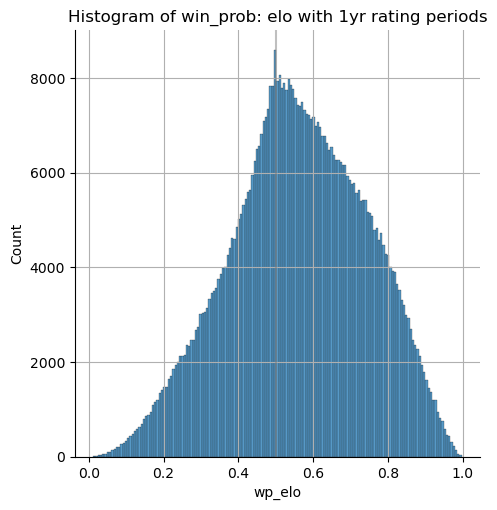

<Figure size 640x480 with 0 Axes>

In [52]:
sns.displot(data = data, x = 'wp_elo').set(
    title = 'Histogram of win_prob: elo with 1yr rating periods')
plt.axvline(.5,0,17500, c= 'grey', alpha = .5)
plt.grid()
plt.show()
plt.savefig('../Assets/Elo_win_prob',bbox_inches = 'tight')

Note the spike at win_prob = .5, which indicates the number of matches between players that had not been rated in the prior epoch and thus have the default rating of 1500.  It is promising that upon visual inspection, the number of wins with win_prob .4 is only slightly above the number of wins with win_prob of .6.  Likewise there are in the ballpark of 25% of the number of wins with a prob of .2 compared to .8.  However, there does appear to be a gradual overestimation of the win probabilities at the extreme ends of the scale.  For instance, at .9 win prob there appears to be only around 3x the number of wins as at .1 win probability.  The model is perhaps not fully picking up the true volatilities in match performance or accounting for the uncertainty of the players' mean ability.  It is also of note that the mode of the min probability even after accounting for newly seen players is around .5, which suggests that the most common pairing is between similarly rated players.

Next we have a look at the distribution of win probabilities according to the Glicko-2 system.

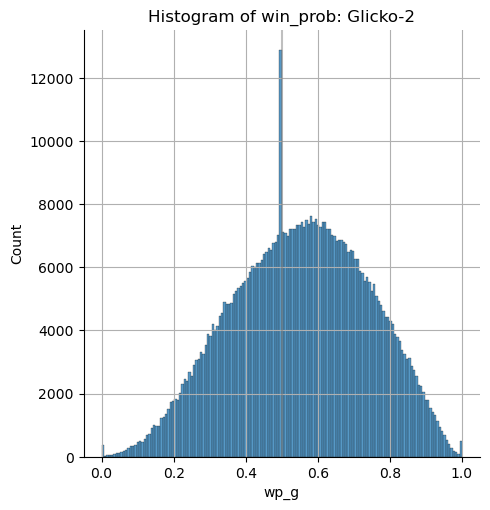

<Figure size 640x480 with 0 Axes>

In [51]:
sns.displot(data = data, x = 'wp_g').set(
    title = 'Histogram of win_prob: Glicko-2')
plt.axvline(.5,0,17500, c= 'grey', alpha = .5)
plt.grid()
plt.show()
plt.savefig('../Assets/Glicko2_win_prob',bbox_inches = 'tight')

Glicko-2's win probability estimates are more rounded and have a larger number of matches between 'unrated' players or players not yet seen before.  The discrepancy here with the elo rating system can be attributed to as-yet unidentified quirks in the Glicko-2 deployment that were sidestepped through try-except clauses as well as filtering.  After accounting for matches between unrated players, the mode is around .58, while there is a smoother transition in the shape of the distribution when comparing the left of the mode to the right of the mode than there was with the elo rating.

Now we will look at the distribution of the rank points differential between the eventual winner and the loser.

In [9]:
rankpoints_diff = data['winner_rank_points'] - data['loser_rank_points']

In [10]:
rankpoints_diff.head()

0   -62.0
1     4.0
2    78.0
3    77.0
4    85.0
dtype: float64

In [11]:
# The winner has on average 120 more rank points than the loser.
np.mean(rankpoints_diff.values)

119.29144952454823

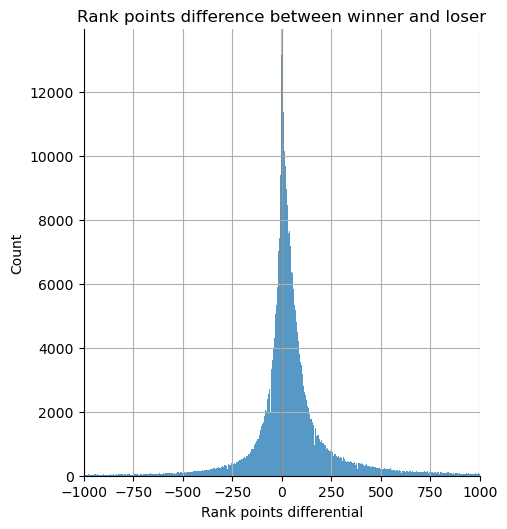

<Figure size 640x480 with 0 Axes>

In [12]:
sns.displot(data = rankpoints_diff).set(
    title = 'Rank points difference between winner and loser', 
    xlim = [-1000,1000], xlabel = 'Rank points differential')
plt.axvline(.5,0,17500, c= 'grey', alpha = .5)
plt.grid()
plt.show()
plt.savefig('../Assets/Rank_points_differential_winner_loser',bbox_inches = 'tight')

Above we see that the mode is very close to if not exactly zero.  This is plausible as we would expect similarly rated players to compete with each other most regularly.  Also, we can see that the center of mass is right of zero, which is to be expected since the mean is positive at 120.

###### Randomization

Randomizing the 'winner' and 'loser' to players a and b is necessary to remove outcome information from the predictive variables.

In [13]:
# a random choice of will will assign the winner to player class A
random.seed(1)
player_indicators = random.choices([0,1],k = data.shape[0])
len(player_indicators)

600797

In [14]:
data['winner_rank_points']

0          36.0
1          46.0
2         158.0
3         110.0
4          98.0
          ...  
600792     51.0
600793      8.0
600794     14.0
600795     15.0
600796      6.0
Name: winner_rank_points, Length: 600797, dtype: float64

In [15]:
# player a is assigned the  winner's info if indicator is 1, otherwise 
# player a gets the loser's info
data.loc[:,'pa_id'] = player_indicators * data['winner_id'] + \
                    abs(np.array(player_indicators)-1) * data['loser_id']
data.loc[:,'pa_pts'] = player_indicators * data['winner_rank_points'] + \
                abs(np.array(player_indicators)-1) * data['loser_rank_points']
data.loc[:,'pa_elo'] = player_indicators * data['winner_elo'] + \
                    abs(np.array(player_indicators)-1) * data['loser_elo']
data.loc[:,'pa_wp_elo'] = (player_indicators * data['wp_elo']) + \
                    abs(np.array(player_indicators)-1) * data['loser_elo']
data.loc[:,'pa_wp_elo'] = player_indicators * data['wp_elo'] + \
                    abs(np.array(player_indicators)-1) * (1-data['wp_elo'])
data.loc[:,'pa_gr'] = player_indicators*data['winner_gr'] + \
                    abs(np.array(player_indicators)-1) * data['loser_gr']
data.loc[:,'pa_grd'] = player_indicators* data['winner_grd'] + \
                     abs(np.array(player_indicators)-1) * data['loser_grd']
data.loc[:,'pa_wp_g'] = player_indicators*data['wp_g'] + \
                        abs(np.array(player_indicators)-1)*(1-data['wp_g'])

# player b initialization
data.loc[:,'pb_id'] = player_indicators * data['loser_id'] + \
                        abs(np.array(player_indicators)-1) * data['winner_id']
data.loc[:,'pb_pts'] = player_indicators * data['loser_rank_points'] + \
               abs(np.array(player_indicators)-1) * data['winner_rank_points']
data.loc[:,'pb_elo'] = player_indicators * data['loser_elo'] + \
                    abs(np.array(player_indicators)-1)*data['winner_elo']
data.loc[:,'pb_wp_elo'] = player_indicators * (1-data['wp_elo'])+ \
                          abs(np.array(player_indicators)-1) * data['wp_elo']
data.loc[:,'pb_gr'] = player_indicators * data['winner_gr'] + \
                    abs(np.array(player_indicators)-1) * data['loser_gr']
data.loc[:,'pb_grd'] = player_indicators * data['winner_grd'] + \
                    abs(np.array(player_indicators)-1) * data['loser_grd']
data.loc[:,'pb_wp_g'] = player_indicators * data['wp_g'] + \
                    abs(np.array(player_indicators)-1) * data['loser_grd']

# player a wins if outcome is 1, otherwise if outcome is 0 player b wins
data.loc[:,'outcome'] = player_indicators

# select randomized data for modeling



In [16]:
# select randomized data for modeling.
d_r = data.iloc[:,-15:]

###### Feature engineering

I'll next create the two predictors of the victor: differential in rank points and weighted differential in rank points.  

For the highest ranked players, say in the top ten, raw ranking point differential may understate the closeness in ability, while for the lower ranked players with very few ranking points the raw ranking point differential may not identify the full extent of ability differentials.

In [17]:
# raw differential in rank points between players 
d_r['rp_diff'] = d_r['pa_pts'] - d_r['pb_pts']

# differential weighted by the inverse of the sum of both players' rank points
d_r['rp_wt_diff'] = d_r['rp_diff']/ (d_r['pa_pts'] + d_r['pb_pts'])

###### Train Test Split

Here I split the data into train and test sets so that the same split can be used for the different models.

In [18]:
d_r.columns

Index(['pa_id', 'pa_pts', 'pa_elo', 'pa_wp_elo', 'pa_gr', 'pa_grd', 'pa_wp_g',
       'pb_id', 'pb_pts', 'pb_elo', 'pb_wp_elo', 'pb_gr', 'pb_grd', 'pb_wp_g',
       'outcome', 'rp_diff', 'rp_wt_diff'],
      dtype='object')

In [19]:
X  = d_r.drop('outcome', axis = 1)

In [20]:
X  = d_r.drop('outcome', axis = 1)
y = d_r['outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, 
                                                    random_state= 1)

#### Rank points model

In this first modeling effort I will see how well ranking points predict the outcomes of matches.

###### Baseline model

The baseline model will predict the winner based on simply who has more rating points.

In [21]:
# since outcome = 1 if Player A wins, if pa_pts > pb_pts when the outcome is
# one that means that this baseline model predicts correctly.
baseline_preds = np.greater(X_test['pa_pts'],np.array(X_test['pb_pts']))
np.equal(baseline_preds, np.array(y_test)).sum()/y_test.shape[0]

0.6424766977363515

Above we see that the ranking points comparison predicts the winner accurately 64.3% of the time on the test set.

###### Logistic Regression

Since this is a classification problem I will see how logistic regression performs.  I will include regularization to ensure that all predictors are useful.

In [22]:
# I will initialize with regularizations between 1.e-01 and 1.e+03
logreg = LogisticRegressionCV(Cs = np.logspace(-1,3,5),fit_intercept = False)

First I will perform the baseline estimation based on raking differential with logistic regression so that a comparison can be made in terms of the probability estimates of the victor.

In [23]:
# generate a dataframe for use in the baseline prediction.  Value true if player A has more points
X_train_b = np.greater(X_train['pa_pts'],np.array(X_train['pb_pts'])).to_frame()
X_test_b = np.greater(X_test['pa_pts'],np.array(X_test['pb_pts'])).to_frame()

In [24]:
logreg.fit(X_train_b,y_train)

LogisticRegressionCV(Cs=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     fit_intercept=False)

In [25]:
logreg.score(X_train_b,y_train), logreg.score(X_test_b,y_test)

(0.6444339398620053, 0.6424766977363515)

Above we can see that the the test score is exactly when the baseline prediction is run through logistic regression.  

In [26]:
X_test_b.head()

,pa_pts
15677,False
77556,False
135675,True
275192,False
263943,False


In [27]:
logreg.predict_proba(X_test_b)[0:5]

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.35357508, 0.64642492],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ]])

In [28]:
logreg.predict(X_test_b)[0:5]

array([0, 0, 1, 0, 0])

Interestingly, logistic regression assigns a probability of 50% to a Player B victory while it assigns a probability of 64.62% to the chance of a Player A victory when Player A has more points.

I will now look at the result of including more rank points features in the regression.

In [29]:
cols_lr = ['pa_pts','pb_pts', 'rp_diff','rp_wt_diff']

In [30]:
logreg.fit(X_train[cols_lr], y_train)

LogisticRegressionCV(Cs=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     fit_intercept=False)

In [31]:
print(logreg.score(X_train[cols_lr], y_train))
print(logreg.score(X_test[cols_lr], y_test))

0.6444339398620053
0.6424633821571238


With 64.45 (train) and 64.29 (test) percent accuracy in predicting the winner, the rating points data does a reasonable job of predicting the outcome.  There is no improvement however over the baseline model.  

In [32]:
logreg.coef_, logreg.intercept_, logreg.C_

(array([[ 6.25872185e-05, -6.38221705e-05,  1.26409389e-04,
          1.31996169e+00]]),
 array([0.]),
 array([0.1]))

The above confirms that there is significant regularization, with the only parameter maintaining a meaningful significance being the weighted points differential.  However, the nearly identical accuracy score confirms that there is nearly perfect correlation between the two predictors.

In [33]:
logreg.predict_proba(X_test[cols_lr])[0:5]

array([[0.61522461, 0.38477539],
       [0.67982876, 0.32017124],
       [0.21244887, 0.78755113],
       [0.76269768, 0.23730232],
       [0.64783174, 0.35216826]])

The weighted rank points differential generates a much more nuanced prediction probability.

In [34]:
np.mean(logreg.predict(X_test[cols_lr]) == baseline_preds)

0.999960053262317

The predictions are almost always the same.

In [35]:
X_test[logreg.predict(X_test[cols_lr]) != baseline_preds][['pa_pts','pb_pts']].head()

,pa_pts,pb_pts
107160,1080.0,1079.0
570862,1026.0,1025.0
148893,1561.0,1558.0
93194,912.0,911.0
155297,1515.0,1513.0


Above we can see that this logreg model that includes the raw player a and player b ranking points is producting some undesirable results when the two players have very similar ratings.  I will now use only the weighted rank differential and see if the results are as expected.

In [36]:
cols_lr = ['rp_wt_diff']

In [37]:
logreg.fit(X_train[cols_lr], y_train)

LogisticRegressionCV(Cs=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     fit_intercept=False)

In [38]:
logreg.coef_, logreg.intercept_, logreg.C_

(array([[1.40620977]]), array([0.]), array([0.1]))

In [39]:
logreg.predict_proba(X_test[cols_lr])[0:5]

array([[0.60263733, 0.39736267],
       [0.688528  , 0.311472  ],
       [0.20150512, 0.79849488],
       [0.77569859, 0.22430141],
       [0.65539488, 0.34460512]])

In [40]:
np.mean(logreg.predict(X_test[cols_lr]) == baseline_preds)

1.0

This issue is now fixed and the higher rated player is always predicted to win.

##### Model Evaluation

In [41]:
print(logreg.score(X_train[cols_lr], y_train))
print(logreg.score(X_test[cols_lr], y_test))

0.6444339398620053
0.6424766977363515


The accuracy of this model is 64.29% for the test set and so we can say that the model predicts on unseen data correctly 64.29% of the time.

In [42]:
preds = logreg.predict(X_test[cols_lr])
pp = pprint.PrettyPrinter(indent = 0)
pp.pprint(classification_report(y_test,preds,output_dict=True))

{'0': {'f1-score': 0.6434594393615467,
     'precision': 0.6409656084656085,
     'recall': 0.6459727517530061,
     'support': 75014},
'1': {'f1-score': 0.6414885236270412,
     'precision': 0.6440080428954423,
     'recall': 0.6389886415024074,
     'support': 75186},
'accuracy': 0.6424766977363515,
'macro avg': {'f1-score': 0.6424739814942939,
             'precision': 0.6424868256805254,
             'recall': 0.6424806966277068,
             'support': 150200},
'weighted avg': {'f1-score': 0.6424728530072555,
                'precision': 0.6424885676869233,
                'recall': 0.6424766977363515,
                'support': 150200}}


From the classification report all of the output dictionaries give the same practical insight into the performance of the model, but the macro weighted avg gives the theoretically most sound analysis as distinguishing between the player classes A and B is not meaningful as the players are arbitrarily assigned to each class.

We can see that with the weighted average, the precision, recall, and f1-scores are all around .6429.  The precision is the number of true positives divided by the number of predicted positives and so a precision of .6429 means that of all the predicted wins, 64.29% are actual wins.  Likewise for recall, of all the actual wins, 64.29% were predicted to be wins.  Since the f1-score is the harmonic mean between these two metrics, or 2*(precision*recall)/(precision + recall), it is to be expected that this metric is also .6429.

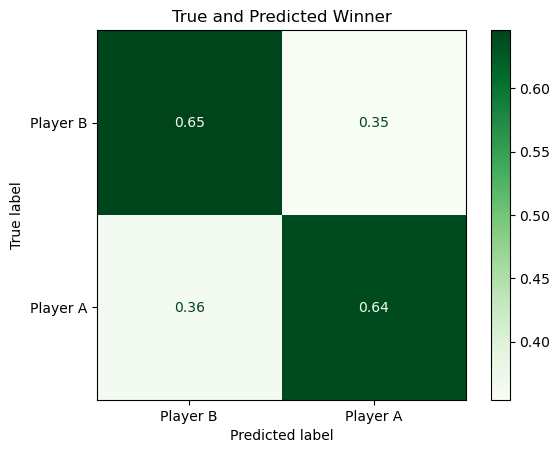

In [54]:
cm_disp = ConfusionMatrixDisplay.from_estimator(logreg, 
                X_test[cols_lr], y_test, cmap="Greens",
                display_labels=['Player B','Player A'], 
                normalize='true').ax_.set_title('True and Predicted Winner')
plt.savefig('../Assets/Logreg_cm.png')

From the above we see as expected very balanced output, with Player B being predicted to win 65% of the time when Player B did actually win, while Player A was predicted to win 64% of the time when Player A did actually win.  Since players were randomly assigned labels A and B, this symmetry is to be expected and any differences can be attributed to randomness.

##### Elo Analysis

I will next investigate the predictive power of elo ratings.  The initial analysis will not include any filtering.

In [44]:
np.equal((X_train['pa_wp_elo']>.5),y_train).mean(),\
np.equal((X_test['pa_wp_elo']>.5),y_test).mean()

(0.6314001202848665, 0.6317177097203729)

Above we see that with the test set 63% of the elo predictions are on the mark.  This is ~ 1.3% less than what we saw with logistic regression.  Since the first time a player features in the dataset they will not have any elo information but will have the default elo rating of 1500, I will next filter out matches for which both players have a rating of 1500.  I will also return to using the full player class randomized dataset without the train and test split since no parameters are being fit.

In [45]:
print(d_r.query('pa_elo != 1500 and pb_elo != 1500').shape[0]/d_r.shape[0])
d_elo = d_r.query('pa_elo != 1500 and pb_elo != 1500')

0.9766293773104726


This filtering maintains 97.66% of the data.  Lets see if there is a change in the predictive power. 

In [46]:
np.equal((d_elo['pa_wp_elo']>.5),d_elo['outcome']).mean()

0.6324741459823163

The predictive accuracy has improved to 63.25%, which is a noticable but still a marginal improvement.  Next steps could include counting the number of matches that are in the elo rating and get a look at how many it takes to get good confidence in the rating.

###### Glicko-2 Analysis

I will next investigate the predictive power of Glicko-2 ratings.  The initial analysis will not include any filtering.

In [47]:
# lets look at accuracies on the train, test, and full dataset.  
np.equal((X_train['pa_wp_g']>.5),y_train).mean(),\
np.equal((X_test['pa_wp_g']>.5),y_test).mean(),\
np.equal((d_r['pa_wp_g']>.5),d_r['outcome']).mean()

(0.6075872675583726, 0.6089747003994673, 0.6079341275006367)

Surprisingly, there is a large decrease in the predictive power of Glicko-2 ratings compared to both elo and ranking points.  The accuracy 60.8% is quite a bit lower than the 64.29% accuracy of the rating point data and the 63.25% accuracy of the elo ratings.  Lets next see if there is anything to be gained by filtering for matches where the players don't both have ratings of 1500, which suggest the rating system has not yet seen the players.

In [48]:
print(d_r.query('pa_gr != 1500 and pb_gr != 1500').shape[0]/d_r.shape[0])
d_g = d_r.query('pa_gr != 1500 and pb_gr != 1500')

0.9495004136172451


95% of the data is still available for prediction after this filter.

In [49]:
np.equal((d_g['pa_wp_g']>.5),d_g['outcome']).mean()

0.6178905684389884

After this filter, the predictive accuracy is up to 61.77% which is still around 1.5% less than the elo rating system.  Lets now look to see how the prediction probabilities compare with MSE as the evaluation metric.

In [50]:
mean_squared_error(d_g['outcome'],d_g['pa_wp_g']),\
mean_squared_error(d_g['outcome'],d_g['pa_wp_elo']),\
mean_squared_error(y_test, preds)

(0.23183412987531077, 0.22538086624632353, 0.3575233022636485)

Above we see that while ratings did the best job of predicting the outcome of the match, the lowest mean_squared_error is seen with Elo followed by Glicko-2.  Thus, the Elo and Glicko-2 rating systems are better at estimating the percentage of time one player should win against another.